# Stima malati reali

Stima incidenza di malati reali su casi testati.

> Max Pierini

***

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from IPython.display import display, Markdown

In [2]:
SEm = .95
SPm = .98
SEa = .70
SPa = .95

In [3]:
df = pd.read_csv(
    "https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/"
    "dpc-covid19-ita-andamento-nazionale.csv",
    parse_dates=['data'], index_col='data'
)
df.index = df.index.normalize()

In [4]:
cols = [
    'totale_casi',
    'tamponi',
    'casi_testati',
    'totale_positivi_test_molecolare',
    'totale_positivi_test_antigenico_rapido', 
    'tamponi_test_molecolare',
    'tamponi_test_antigenico_rapido'
]

In [5]:
df_prev = df[cols].diff()

In [6]:
df_prev.loc[df_prev.totale_casi<0, 'totale_casi'] = np.nan

In [7]:
df_prev.loc[df_prev.casi_testati<0, 'casi_testati'] = np.nan

In [8]:
df_prev.fillna(method='ffill', inplace=True)

In [9]:
df_prev['TP_testati'] = df_prev.totale_casi / df_prev.casi_testati

In [10]:
df_prev.loc[df_prev.TP_testati<=0, 'TP_testati'] = np.nan

In [11]:
df_diff = df[cols].diff().dropna()

In [12]:
df_diff['ratio_molecolare'] = df_diff.totale_positivi_test_molecolare / df_diff.tamponi_test_molecolare

In [13]:
df_diff['TP_molecolare'] = df_diff.totale_positivi_test_molecolare / df_diff.casi_testati

In [14]:
df_diff['ratio_antigenico'] = df_diff.totale_positivi_test_antigenico_rapido / df_diff.tamponi_test_antigenico_rapido

In [15]:
df_diff['TP_antigenico'] = df_diff.totale_positivi_test_antigenico_rapido / df_diff.casi_testati

In [16]:
df_diff['TP_tamponi'] = df_diff.totale_casi / df_diff.tamponi

In [17]:
df_diff['TP_testati'] = df_diff.totale_casi / df_diff.casi_testati

In [18]:
VPm = df_diff.totale_positivi_test_molecolare * SEm
VPa = df_diff.totale_positivi_test_antigenico_rapido * SEa

FPm = df_diff.totale_positivi_test_molecolare * (1 - SPm)
FPa = df_diff.totale_positivi_test_antigenico_rapido * (1 - SPa)

In [19]:
VP = VPm + VPa
FP = FPm + FPa

In [20]:
PmT = df_diff.tamponi_test_molecolare / (
    df_diff.tamponi_test_antigenico_rapido +
    df_diff.tamponi_test_molecolare
)

In [21]:
T_N = df_diff.casi_testati - df_diff.totale_casi

In [22]:
TNm = T_N * PmT
TNa = T_N * (1 - PmT)

In [23]:
VNm = TNm * SPm
VNa = TNa * SPa

FNm = TNm * (1 - SEm)
FNa = TNa * (1 - SEa)

In [24]:
positivi = (VPm + VPa + FNm + FNa)
negativi = (VNm + VNa + FPm + FPa)
totali = df_diff.casi_testati

In [25]:
#exp_TP = pd.DataFrame((positivi / (positivi + negativi)))
exp_TP = pd.DataFrame(positivi / totali)
exp_TP.columns = ['incidenza malati su casi testati']

In [26]:
err = pd.DataFrame(exp_TP['incidenza malati su casi testati'] - df_diff.TP_testati)
err.columns = ['errore incidenza - positivi']

In [27]:
display(Markdown(fr"""
# Abstract

> Date sensibilità **SE** e specificità **SP** dei test, 
la proporzione dei _veri malati_ (infetti)
sul numero totale di casi testati non coincide
con il numero di positivi, perché **SE** ed **SP**
comportano una probabilità non nulla di falsi negativi
e falsi positivi. Si stima qui l'incidenza giornaliera di infetti
reali sui casi testati per determinare quanto gli attuali
test per COVID-19 siano in grado di individuare
i reali infetti. I risultati mostrano come la
percentuale di infetti reali sia mediamente
{err.mean().values[0]*100:.1f}%
({err.min().values[0]*100:.1f}-{err.max().values[0]*100:.1f}%) maggiore
rispetto ai test positivi (molecolari e antigenici).

***
"""))


# Abstract

> Date sensibilità **SE** e specificità **SP** dei test, 
la proporzione dei _veri malati_ (infetti)
sul numero totale di casi testati non coincide
con il numero di positivi, perché **SE** ed **SP**
comportano una probabilità non nulla di falsi negativi
e falsi positivi. Si stima qui l'incidenza giornaliera di infetti
reali sui casi testati per determinare quanto gli attuali
test per COVID-19 siano in grado di individuare
i reali infetti. I risultati mostrano come la
percentuale di infetti reali sia mediamente
11.9%
(10.4-13.2%) maggiore
rispetto ai test positivi (molecolari e antigenici).

***


# Metodo

Si suppone che

- i nuovi casi testati giornalieri $\odot$ comunicati dal Dipartimento di Protezione Civile (DPC) siano soggetti testati giornalieri mai risultati positivi

- i test totali _TOT_ comunicati dal DPC siano test che comprendono anche controlli e follow-up a soggetti anche già risultati positivi

si stima pertanto l'incidenza reale $I$ di malatti reali $M$ sui casi testati giornalieri, ovvero $I=M/\odot$.

I casi testati totali giornalieri $\odot$ sono somma la dei casi testati positivi $\oplus$ e negativi $\ominus$

$$
\odot = \oplus + \ominus
$$

Dinstinguendo tra test molecolari $m$ e antigenici $a$, i test positivi sono la somma dei positivi molecolari $\oplus_m$ e antigenici $\oplus_a$. Ugualmente diremo per i testi negativi molecolari $\ominus_m$ e antigenici $\ominus_a$

$$
\oplus = \oplus_m + \oplus_a \;\;,\;\; \ominus = \ominus_m + \ominus_a
$$

Notiamo però che i **malati reali** $M$ sono la somma di veri positivi VP e falsi negativi FN

$$
M = \mathrm{VP} + \mathrm{FN}
$$

parimenti, i **non malati reali** $\overline{M}$ sono la somma di veri negativi VN e falsi positivi FP

$$
\overline{M} = \mathrm{VN} + \mathrm{FP}
$$

avendo però molecolari e antigenici differenti sensibilità **SE** e specificità **SP** e sapendo che

$$
\mathbf{SE} = p(\oplus|M) = p(\mathrm{VP})
$$

$$
1 - \mathbf{SE} = p(\ominus|M) = p(\mathrm{FN})
$$

$$
\mathbf{SP} = p(\ominus|\overline{M}) = p(\mathrm{VN})
$$

$$
1 - \mathbf{SP} = p(\oplus|\overline{M}) = p(\mathrm{FP})
$$

separiamo malati reali da test molecolare e antigenico

$$
M_m = \mathrm{VP}_m + \mathrm{FN}_m \;\;,\;\; M_a = \mathrm{VP}_a + \mathrm{FN}_a
$$

$$
\overline{M}_m = \mathrm{VN}_m + \mathrm{FP}_m \;\;,\;\; \overline{M}_a = \mathrm{VN}_a + \mathrm{FP}_a
$$

si stimano pertanto VP, VN, FP ed FN da molecolari ed antigenici in base alle formule di **SE** ed **SP**.

Avremo quindi per i molecolari

$$
\mathrm{VP}_m = \mathbf{SE}_m \oplus_m \;\;,\;\; \mathrm{FP}_m = (1 - \mathbf{SP}_m) \oplus_m
$$

$$
\mathrm{VN}_m = \mathbf{SP}_m \ominus_m \;\;,\;\; \mathrm{FN}_m = (1 - \mathbf{SE}_m) \ominus_m
$$

e per gli antigenici

$$
\mathrm{VP}_a = \mathbf{SE}_a \oplus_a \;\;,\;\; \mathrm{FP}_a = (1 - \mathbf{SP}_a) \oplus_a
$$

$$
\mathrm{VN}_a = \mathbf{SP}_a \ominus_a \;\;,\;\; \mathrm{FN}_a = (1 - \mathbf{SE}_a) \ominus_a
$$

Note sensibilità, specificità e test positivi di molecolari e antigenici, possiamo facilmente calcolare veri e falsi positivi. Per stimare però veri e falsi negativi manca il dato di test negativi (perché il dato dei test totali _TOT_ molecolari e antigenici comunicato dal DPC è comprensivo di test di controllo e follow-up che, anche in caso di positività, non verrebbero mai comunicati come _nuovi casi positivi_). Si suppone pertanto che il rapporto negativi molecolari su totali sia proporzionale ad un parametro $k$ che stimiamo come rapporto tra test totali molecolari $TOT_m$ e test totali $TOT_m+TOT_a$

$$
k = \frac{ TOT_m }{ TOT_m + TOT_a }
$$

Il totale dei casi testati negativi è 

$$
\ominus = \odot - \oplus
$$

stimiamo quindi i test negativi molecolari $\mathbb{E}[\ominus_m]$ e antigenici $\mathbb{E}[\ominus_a]$

$$
\mathbb{E}[\ominus_m] \simeq k \ominus \;\;,\;\; \mathbb{E}[\ominus_a] \simeq (1-k) \ominus
$$

possiamo così stimare il totale dei malati reali

$$
M = \mathrm{VP}_m + \mathrm{VP}_a + \mathrm{FN}_m + \mathrm{FN}_a
$$

come

$$
\mathbb{E}[M] = 
\mathbf{SE}_m \oplus_m + 
\mathbf{SE}_a \oplus_a + 
(1 - \mathbf{SE}_m) \mathbb{E}[\ominus_m] + 
(1 - \mathbf{SE}_a) \mathbb{E}[\ominus_a]
$$

dunque l'incidenza giornaliera stimata sui casi testati risulterà

$$
\mathbb{E}[I] = \frac{ \mathbb{E}[M] }{ \odot }
$$

Notiamo che dipende soprattutto dalla sensibilità **SE**.

In [28]:
display(Markdown(fr"""
Da [ScienzaInRete](https://www.scienzainrete.it/articolo/test-nasofaringeo-antigenico-rapido-controllo-della-epidemia-come-e-quando-utilizzarlo)
sappiamo che per i molecolari

$$
\mathbf{{SE}}_m = {SEm*100:.0f}\% \;\;,\;\; \mathbf{{SP}}_m = {SPm*100:.0f}\%
$$

e per gli antigenici

$$
\mathbf{{SE}}_a = {SEa*100:.0f}\% \;\;,\;\; \mathbf{{SP}}_a = {SPa*100:.0f}\%
$$
"""))


Da [ScienzaInRete](https://www.scienzainrete.it/articolo/test-nasofaringeo-antigenico-rapido-controllo-della-epidemia-come-e-quando-utilizzarlo)
sappiamo che per i molecolari

$$
\mathbf{SE}_m = 95\% \;\;,\;\; \mathbf{SP}_m = 98\%
$$

e per gli antigenici

$$
\mathbf{SE}_a = 70\% \;\;,\;\; \mathbf{SP}_a = 95\%
$$


# Risultati

Incidenza giornaliera di malati reali su casi testati nell'ultima settimana (in percentuale)

In [29]:
exp_TP.tail(7) * 100

,incidenza malati su casi testati
data,
2021-01-18,30.343497
2021-01-19,27.768520
2021-01-20,26.810020
2021-01-21,26.391506
2021-01-22,28.733357
2021-01-23,28.431508
2021-01-24,26.601145


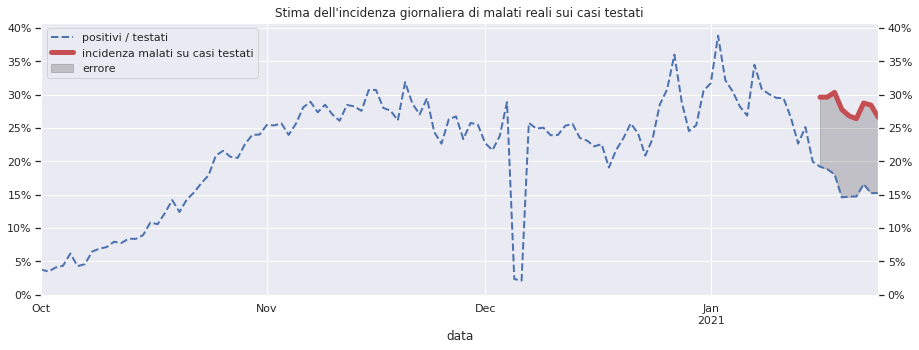

In [30]:
fig, ax = plt.subplots(figsize=(15, 5), sharex=True)

df_prev.plot(y='TP_testati', ax=ax, label='positivi / testati', ls='--', lw=2)

exp_TP.plot(y='incidenza malati su casi testati', color='r', ax=ax, lw=5)

ax.fill_between(
    exp_TP.index,
    df_prev[df_prev.index>=exp_TP.index[0]].TP_testati,
    exp_TP['incidenza malati su casi testati'],
    color='k', alpha=.2,
    label='errore'
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
ax.yaxis.set_ticks_position('both')
ax.tick_params(labeltop=False, labelright=True)
ax.set(
    title="Stima dell'incidenza giornaliera di malati reali sui casi testati",
    ylim=(0, np.max([.4, ax.get_ylim()[1]])),
    xlim=('2020-10-01', ax.get_xlim()[1])
)
ax.legend(loc='upper left')

plt.show()

Errore tra incidenza giornaliera stimata di malati (infetti) e test positivi sui casi testati (ultima settimana)

In [31]:
(err * 100).tail(7)

,errore incidenza - positivi
data,
2021-01-18,12.289817
2021-01-19,13.166609
2021-01-20,12.101204
2021-01-21,11.652622
2021-01-22,12.146988
2021-01-23,13.199387
2021-01-24,11.360703


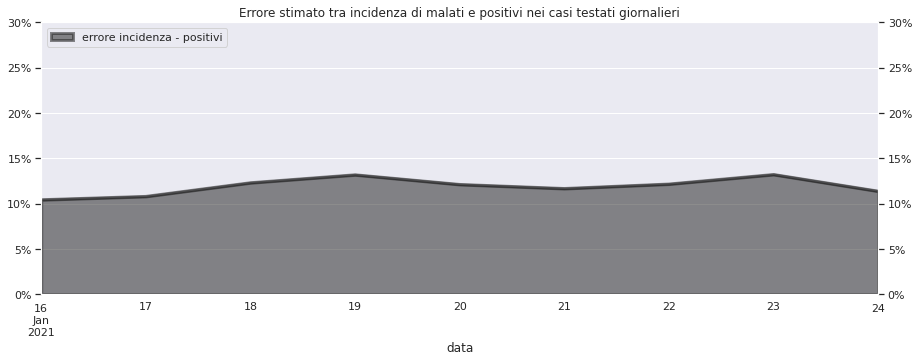

In [32]:
fig, ax = plt.subplots(figsize=(15, 5), sharex=True)

err.plot(
    y='errore incidenza - positivi', 
    label='errore incidenza - positivi', 
    ax=ax, lw=3, kind='area',
    alpha=.5, color='k'
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
ax.yaxis.set_ticks_position('both')
ax.tick_params(labeltop=False, labelright=True)
ax.set(
    title='Errore stimato tra incidenza di malati e positivi nei casi testati giornalieri',
    ylim=(0, np.max([.3, ax.get_ylim()[1]])),
)
ax.legend(loc='upper left')

plt.show()